# <center>Bad Bank Behavior<br>Analyzing Bank Mortgage during the 2007 Housing Bubble</center>  

<center>Michael Siebel</center>
<center>August 2020</center>

<br>
    
## Table of Contents
- [Goals](#Goals)<br>
- [Load Packages](#Load-Packages)<br>
- [Set Up Functions](#Set-Up-Functions)<br>
- [Implement Data Cleanings](#Implement-Data-Cleanings)<br>
- [Analysis Functions](#Analysis-Functions)<br>
- [Imbalanced Prediction](#Imbalanced-Prediction)
- [Downsampling Prediction](#Downsampling-Prediction)<br>
- [Upsampling Prediction](#Upsampling-Prediction)<br>
- [Conclusion](#Conclusion)<br>

# Goals  
<br>

 

***

# Load Functions

In [41]:
# Load functions and data
%run Functions.ipynb
pd.set_option("display.max_columns", 999)

file_to_open = open('..\Data\df.pkl', 'rb') 
df  = pickle.load(file_to_open) 
file_to_open.close()

# Drop mergeID column
df = df.drop(labels='Loan ID', axis=1)

***

# Modeling

Keep:
AMTRUST BANK
BANK OF AMERICA, N.A.
CITIMORTGAGE, INC.
FIRST TENNESSEE BANK NATIONAL ASSOCIATION
FLAGSTAR CAPITAL MARKETS CORPORATION	
GMAC MORTGAGE, LLC
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
OTHER	
PNC BANK, N.A.
SUNTRUST MORTGAGE INC.

Small:
BISHOPS GATE RESIDENTIAL MORTGAGE TRUST
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB
FREEDOM MORTGAGE CORP.
GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)
HSBC BANK USA, NATIONAL ASSOCIATION
PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK)
THIRD FEDERAL SAVINGS AND LOAN
WELLS FARGO BANK, N.A.

Collapse:
CHASE HOME FINANCE	
CHASE HOME FINANCE (CIE 1)	
CHASE HOME FINANCE, LLC

In [45]:
# Verify Bank Counts
df['Bank'].value_counts()

BANK OF AMERICA, N.A.                        371423
OTHER                                        213459
CITIMORTGAGE, INC.                           135536
SMALL LOAN BANKS                             112134
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION     88255
GMAC MORTGAGE, LLC                            75599
PNC BANK, N.A.                                63726
SUNTRUST MORTGAGE INC.                        53548
AMTRUST BANK                                  38024
FLAGSTAR CAPITAL MARKETS CORPORATION          34789
FIRST TENNESSEE BANK NATIONAL ASSOCIATION     28718
CHASE HOME FINANCE                            15791
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB       9966
Name: Bank, dtype: int64

In [ ]:
# Variables to drop
dropvars = ['Original Date', 'File Year', 'File Quarter', 'Month', 'Region',
            'Zip Code', 'Mortgage Insurance Type']  # 'Property State', 

# All Data
All_X = df.drop(labels=dropvars, axis=1)
All_y = All_X['Foreclosed']
All_X = All_X.drop(labels='Foreclosed', axis=1) 

# split dataset
X_train, X_test, y_train, y_test = train_test_split(All_X, All_y, test_size = 0.3, 
                                                    stratify = All_y, random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, 
                                                stratify = y_test, random_state=2020)

# One hot encoding on remaining data
X_train = onehotencoding(X_train)
X_test = onehotencoding(X_test) 
X_val = onehotencoding(X_val)

# Print features
print(X_cols)

In [46]:
# List of banks
Banks = ['AMTRUST BANK', 'BANK OF AMERICA, N.A.', 'CITIMORTGAGE, INC.', 
         'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB', 
         'FIRST TENNESSEE BANK NATIONAL ASSOCIATION', 'FLAGSTAR CAPITAL MARKETS CORPORATION', 
         'GMAC MORTGAGE', 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION', 'OTHER', 
         'PNC BANK, N.A.', 'SUNTRUST MORTGAGE INC.', 'CHASE HOME FINANCE', 'SMALL LOAN BANKS']

# Function to subset banking datasets
def Bank_Subsets(bank_strs, df_X = X_train, df_y = y_train):
    # Initiate Bank dictionaries
    X = {}
    y = {}

    # Bank Subset
    for bank_str in bank_strs:
        X[bank_str] = df_X.loc[:, df_X[str('Bank_' + bank_str)]==1] \
            .filter(regex=r'^(?!Bank_).*$')
        y[bank_str] = df_y[np.array(df_X[str('Bank_' + bank_str)]==1)]
    
    return X, y

# Run Function
Banks_X, Banks_y = Bank_Subsets(Banks)

In [48]:
# Define models
model_rfbal = BalancedRandomForestClassifier(n_estimators=200, random_state=2020, 
                                             max_features=0.25, 
                                             replacement=True, sampling_strategy='auto', n_jobs=-1)
model_bagbal = BalancedBaggingClassifier(n_estimators=200, random_state=2021, 
                                         max_features=0.25, 
                                         replacement=True, sampling_strategy='auto', n_jobs=-1)
model_rfsubbal = BalancedRandomForestClassifier(n_estimators=1000, random_state=2022, 
                                                max_features=0.5, 
                                                sampling_strategy={0:500, 1:500}, 
                                                replacement=True, n_jobs=-1)
model_bagsubbal = BalancedBaggingClassifier(n_estimators=1000, random_state=2023, 
                                            max_features=0.5, 
                                            sampling_strategy={0:500, 1:500}, 
                                            replacement=True, n_jobs=-1)
model_rfsub = RandomForestClassifier(n_estimators=1000, random_state=2024, 
                                     max_features=0.75, n_jobs=-1)
model_bagsub = BaggingClassifier(n_estimators=1000, random_state=2025, 
                                 max_features=0.75, n_jobs=-1)

# model_wgt = RandomForestClassifier(n_estimators=500, random_state=2020, max_features='sqrt', 
#                                    class_weight={1: 0.1, 0: 0.9}, n_jobs=-1)
# model_und = RUSBoostClassifier(n_estimators=50, random_state=2020)
# model_reg = RandomForestClassifier(n_estimators=50, random_state=2020, max_features=0.25, n_jobs=-1)
# model_eec = EasyEnsembleClassifier(n_estimators=50, random_state=2020)
# ExtraTreesClassifier
model_knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_log = LogisticRegression(max_iter=100, n_jobs=-1)

In [49]:
# Model Dictionaries
bnk_scalers = {}
bnk_test = {}
bnk_models = {}
bottom_layer = {}
bnk_proba = {}

# Loop
for bank_str in ['AMTRUST BANK']:
    # define datasets
    y = Banks_y[bank_str]
    X = Banks_X[bank_str]
    
    # Standardize Vars
    X_cols = X.columns
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    bnk_X_test = scaler.transform(X_test[X_cols])
    
    # SMOTE
    # sm = SMOTEENN(random_state=2020, n_jobs=-1)
    # X_sm, y_sm = sm.fit_resample(X, y) 
    # X_sm = scaler.transform(X_sm)
    
    # Bottom Layer
    bnk_rfsub = pd.DataFrame(cross_val_predict(model_rfsub, X = X, y = y, method='predict_proba'), 
                             columns=['Did not Foreclose', 'Foreclosed'])
    bnk_bagsub = pd.DataFrame(cross_val_predict(model_bagsub, X, y, method='predict_proba'), 
                              columns=['Did not Foreclose', 'Foreclosed'])   
    bnk_bagsubbal = pd.DataFrame(cross_val_predict(model_bagsubbal, X, y, method='predict_proba'), 
                                columns=['Did not Foreclose', 'Foreclosed'])     
    bnk_rfsubbal = pd.DataFrame(cross_val_predict(model_rfsubbal, X, y, method='predict_proba'), 
                               columns=['Did not Foreclose', 'Foreclosed']) 
    bnk_bagbal = pd.DataFrame(cross_val_predict(model_bagbal, X, y, method='predict_proba'), 
                              columns=['Did not Foreclose', 'Foreclosed'])     
    bnk_rfbal = pd.DataFrame(cross_val_predict(model_rfbal, X, y, method='predict_proba'), 
                             columns=['Did not Foreclose', 'Foreclosed']) 
    #bnk_model_log = model_log.fit(X_sm, y_sm)
    #bnk_log = pd.DataFrame(bnk_model_log.predict_proba(X), columns=['Did not Foreclose', 'Foreclosed'])
    
    bottom_layer[bank_str] = pd.DataFrame({'bnk_rfbal': bnk_rfbal['Foreclosed'], 
                                           'bnk_bagbal': bnk_bagbal['Foreclosed'], 
                                           'bnk_rfsubbal': bnk_rfsubbal['Foreclosed'], 
                                           'bnk_bagsubbal': bnk_bagsubbal['Foreclosed'], 
                                           'bnk_rfsub': bnk_rfsub['Foreclosed'], 
                                           'bnk_bagsub': bnk_bagsub['Foreclosed']})
    
    # Middle Layer
    top_clf = model_log

    
    # Save to Model Dictionaries
    bnk_scalers[bank_str] = scaler
    bnk_test[bank_str] = bnk_X_test
    #bnk_models[bank_str] = top_clf.fit(bottom_layer[bank_str], y)
    #bnk_proba[bank_str] = pd.DataFrame(top_clf.predict_proba(bottom_layer[bank_str]), 
    #                                   columns=['Did not Foreclose', 'Foreclosed'])
    bnk_proba[bank_str] = pd.Series(bottom_layer[bank_str].mean(axis=1))
    print('...completed modeling', bank_str)

...completed modeling AMTRUST BANK


AMTRUST BANK


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


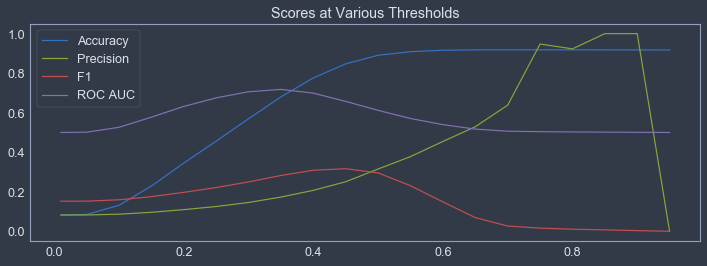

None
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     24545
           1       0.17      0.76      0.28      2206

    accuracy                           0.68     26751
   macro avg       0.57      0.72      0.54     26751
weighted avg       0.90      0.68      0.75     26751

{'Threshold': 0.35, 'Best ROC AUC Score': 0.7179844059433828}


In [53]:
# Check indiv-bank models on training set
for bank_str in ['AMTRUST BANK']:
    print(bank_str)
    # print('Score:', bnk_scores[bank_str].round(3)*100)
    proba = bnk_proba[bank_str]
    print(threshold(proba, Banks_y[bank_str]))

bnk_rfbal


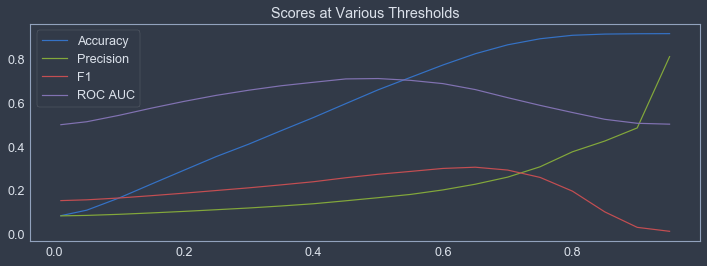

None
              precision    recall  f1-score   support

           0       0.97      0.65      0.78     24545
           1       0.17      0.77      0.27      2206

    accuracy                           0.66     26751
   macro avg       0.57      0.71      0.53     26751
weighted avg       0.90      0.66      0.74     26751

{'Threshold': 0.5, 'Best ROC AUC Score': 0.7120572386611301}
bnk_bagbal


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


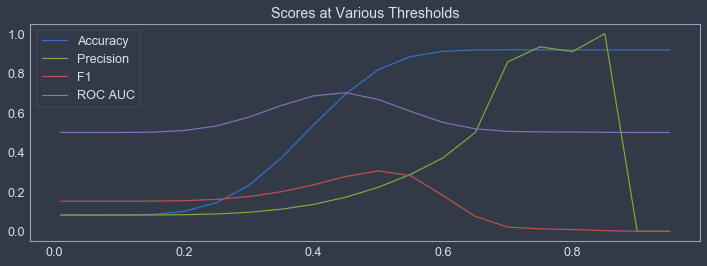

None
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     24545
           1       0.17      0.71      0.28      2206

    accuracy                           0.70     26751
   macro avg       0.57      0.70      0.54     26751
weighted avg       0.90      0.70      0.76     26751

{'Threshold': 0.45, 'Best ROC AUC Score': 0.7013353274380673}
bnk_rfsubbal


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


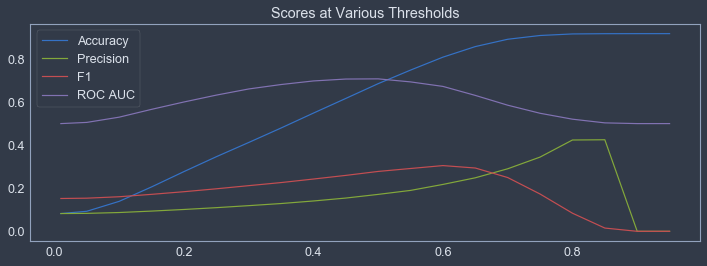

None
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     24545
           1       0.17      0.73      0.28      2206

    accuracy                           0.69     26751
   macro avg       0.57      0.71      0.54     26751
weighted avg       0.90      0.69      0.76     26751

{'Threshold': 0.5, 'Best ROC AUC Score': 0.7076774632860213}
bnk_bagsubbal


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


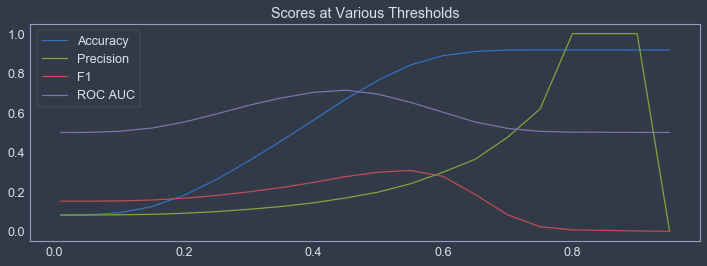

None
              precision    recall  f1-score   support

           0       0.97      0.66      0.79     24545
           1       0.17      0.77      0.28      2206

    accuracy                           0.67     26751
   macro avg       0.57      0.71      0.53     26751
weighted avg       0.90      0.67      0.74     26751

{'Threshold': 0.45, 'Best ROC AUC Score': 0.7140200793147894}
bnk_rfsub


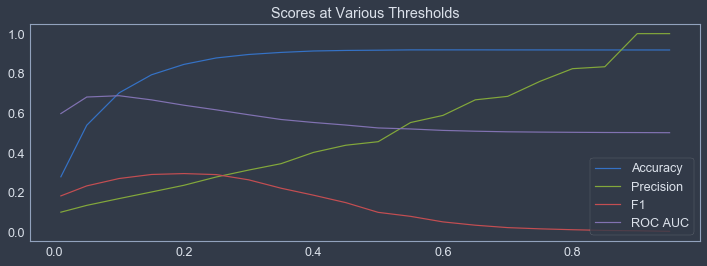

None
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     24545
           1       0.17      0.67      0.27      2206

    accuracy                           0.70     26751
   macro avg       0.56      0.69      0.54     26751
weighted avg       0.89      0.70      0.77     26751

{'Threshold': 0.1, 'Best ROC AUC Score': 0.687389029752188}
bnk_bagsub


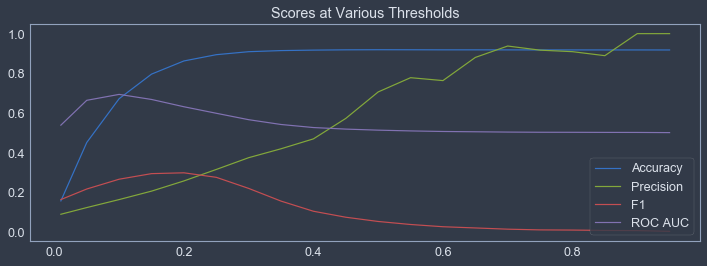

None
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     24545
           1       0.16      0.72      0.27      2206

    accuracy                           0.67     26751
   macro avg       0.56      0.69      0.53     26751
weighted avg       0.90      0.67      0.75     26751

{'Threshold': 0.1, 'Best ROC AUC Score': 0.693516256983168}


In [54]:
# Check indiv-bank models on test set
for model_str in bottom_layer['AMTRUST BANK']:
    subset = np.array(X_train['Bank_AMTRUST BANK']==1)

    print(model_str)
    print(threshold(bottom_layer['AMTRUST BANK'][model_str], y_train[subset]))

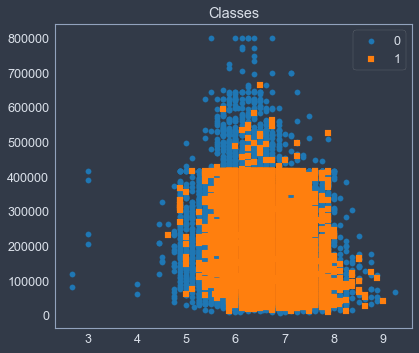

In [55]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
plot_2d_space(np.array(X_test), y_test)

i = 0
vote_clf = pd.DataFrame()
for model_str in ['bnk_rfbal', 'bnk_rfpart', 'bnk_bagbal']:    
    vote_clf = bottom_layer[model_str].map(lambda x: 1 if x >= 0.5 else 0)
    i += 1    

vote_clf['Vote'] = vote_clf.sum(axis=1) 
vote_clf['Tally'] = vote_clf['Vote'].map(lambda x: 1 if x >= 3 else 0)
vote_clf

# Model Dictionaries
bnk_scalers = {}
bnk_test = {}
bnk_models = {}
bnk_scores = {}
bnk_proba = {}

# Loop
for bank_str in ['AMTRUST BANK']:
    # define datasets
    y = Banks_y[bank_str]
    X = Banks_X[bank_str]
    
    # Standardize Vars
    X_cols = X.columns
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    bnk_X_test = scaler.transform(X_test[X_cols])
    
    # Bottom Layer
    estimators = [
        ('bal', model_bal),
        ('und', model_und),
        ('gbm', model_gbm),
        ('wgt', model_wgt),
        ('reg', model_reg)
    ]
    clf = StackingClassifier(
        estimators=estimators, 
        stack_method='predict_proba',
        final_estimator=LogisticRegression(max_iter=100, n_jobs=-1)
    )
    
    # Save to Model Dictionaries
    bnk_scalers[bank_str] = scaler
    bnk_test[bank_str] = bnk_X_test
    bnk_models[bank_str] = clf.fit(X, y)
    bnk_scores[bank_str] = bnk_models[bank_str].score(bnk_X_test, y_test)
    bnk_proba[bank_str] = pd.DataFrame(clf.predict_proba(X), columns=["Did not Foreclose", "Foreclosed"])
    print('...completed modeling', bank_str)

In [56]:
file_to_store = open("..\Data\bnk_scalers.pickle", "wb")
pickle.dump(bnk_scalers, file_to_store)
file_to_store = open("..\Data\bnk_test.pickle", "wb")
pickle.dump(bnk_test, file_to_store)
file_to_store = open("..\Data\bnk_models.pickle", "wb")
pickle.dump(bnk_models, file_to_store)
#file_to_store = open("..\Data\bnk_scores.pickle", "wb")
#pickle.dump(bnk_scores, file_to_store)
file_to_store = open("..\Data\bnk_proba.pickle", "wb")
pickle.dump(bnk_proba, file_to_store)
file_to_store.close()

In [ ]:
'''
file_to_open = open('..\Data\bnk_scalers.pickle', 'rb') 
bnk_scalers = pickle.load(file_to_open)
file_to_open = open('..\Data\bnk_test.pickle', 'rb') 
bnk_test = pickle.load(file_to_open)
file_to_open = open('..\Data\bnk_models.pickle', 'rb') 
bnk_models = pickle.load(file_to_open)
file_to_open = open('..\Data\bnk_scores.pickle', 'rb') 
bnk_scores = pickle.load(file_to_open)
file_to_open = open('..\Data\bnk_proba.pickle', 'rb') 
bnk_proba = pickle.load(file_to_open)
file_to_open.close()
'''

In [ ]:
# Model Dictionaries
all_scalers = {}
all_test = {}
all_models = {}
all_scores = {}
all_proba = {}

# Loop
for bank_str in ['AMTRUST BANK']:
    # define datasets
    y = y_train   
    X = X_train
    readd = X.loc[:, str('Bank_' + bank_str)]
    X = X.filter(regex=r'^(?!Bank_).*$')
    X.loc[:, str('Bank_' + bank_str)] = readd
    
    # Add interaction terms
    X = Bank_Interactions(X)

    # Standardize Vars
    X_cols = X.columns
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    all_X_test = scaler.transform(X_test.loc[:, X_cols])    
    
    # Bottom Layer
    estimators = [
        ('rfbal', model_rfbal),
        ('bagbal', model_bagbal),
        ('rfsubbal', model_rfsubbal),
        ('bagsubbal', model_bagsubbal),
        ('rfsub', model_rfsub),
        ('bagsub', model_bagsub),
    ]
    clf = StackingClassifier(
        estimators=estimators, 
        stack_method='predict_proba',
        final_estimator=LogisticRegression(max_iter=100, n_jobs=-1)
    )
    
    # Save to Model Dictionaries
    all_scalers[bank_str] = scaler
    all_test[bank_str] = all_X_test
    all_models[bank_str] = clf.fit(X, y)
    all_scores[bank_str] = all_models[bank_str].score(all_X_test, y_test)
    all_proba[bank_str] = pd.DataFrame(clf.predict_proba(X), columns=["Did not Foreclose", "Foreclosed"])
    print('...completed modeling', bank_str)

c:\python37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
import pickle
file_to_store = open("..\Data\all_scalers.pickle", "wb")
pickle.dump(all_scalers, file_to_store)
file_to_store = open("..\Data\all_test.pickle", "wb")
pickle.dump(all_test, file_to_store)
file_to_store = open("..\Data\all_models.pickle", "wb")
pickle.dump(all_models, file_to_store)
file_to_store = open("..\Data\all_scores.pickle", "wb")
pickle.dump(all_scores, file_to_store)
file_to_store = open("..\Data\all_proba.pickle", "wb")
pickle.dump(all_proba, file_to_store)
file_to_store.close()

In [ ]:
'''
file_to_open = open('..\Data\all_scalers.pickle', 'rb') 
all_scalers = pickle.load(file_to_open)
file_to_open = open('..\Data\all_test.pickle', 'rb') 
all_test = pickle.load(file_to_open)
file_to_open = open('..\Data\all_models.pickle', 'rb') 
all_models = pickle.load(file_to_open)
file_to_open = open('..\Data\all_scores.pickle', 'rb') 
all_scores = pickle.load(file_to_open)
file_to_open = open('..\Data\all_proba.pickle', 'rb') 
all_proba = pickle.load(file_to_open)
file_to_open.close()
'''

# Check indiv-bank models on training set
for bank_str in ['AMTRUST BANK']:
    print(bank_str)
    print('Score:', bnk_scores[bank_str].round(3)*100)
    proba = bnk_proba[bank_str]['Foreclosed']
    print(threshold(proba, Banks_y[bank_str]))

# Check indiv-bank models on test set
for bank_str in ['AMTRUST BANK']:
    subset = np.array(X_test[str('Bank_' + bank_str)]==1)
    test = bnk_test[bank_str][subset]
    proba = pd.DataFrame(bnk_models[bank_str].predict_proba(test), 
                                       columns=["Did not Foreclose", "Foreclosed"])
    print(bank_str)
    proba = proba['Foreclosed']
    print(threshold(proba, y_test[subset]))

In [ ]:
# Check all-bank models on training set
for bank_str in ['AMTRUST BANK']:
    print(bank_str)  
    print('Score:', all_scores[bank_str].round(3)*100)
    proba = all_proba[bank_str]['Foreclosed']
    print(threshold(proba, y_train))

In [ ]:
# Check all-bank models on test set
for bank_str in ['AMTRUST BANK']:
    subset = np.array(X_test[str('Bank_' + bank_str)]==1)
    test = all_test[bank_str][subset]    
    proba = pd.DataFrame(all_models[bank_str].predict_proba(test), 
                                       columns=["Did not Foreclose", "Foreclosed"])
    print(bank_str)
    proba = proba['Foreclosed']
    print(threshold(proba, y_test[subset]))

In [ ]:
from sklearn.model_selection import cross_val_predict

# Model Dictionaries
bottom_layer = {}
final_models = {}
final_scores = {}
final_proba = {}

# Loop
for bank_str in ['AMTRUST BANK']:
    # Predict onto test data
    subset = np.array(X_test[str('Bank_' + bank_str)]==1)
    final_bnk_proba = pd.DataFrame(bnk_models[bank_str].predict_proba(bnk_test[bank_str][subset]), 
                                   columns=["Did not Foreclose", "Foreclosed"])
    final_all_proba = pd.DataFrame(all_models[bank_str].predict_proba(all_test[bank_str][subset]), 
                                   columns=["Did not Foreclose", "Foreclosed"])
    
    # Define datasets
    bottom_layer[bank_str] = pd.DataFrame({'Ind Banks': final_bnk_proba['Foreclosed'], 
                                           'All Banks': final_all_proba['Foreclosed']})

    # Top Layer
    clf = LogisticRegression(max_iter=100, n_jobs=-1)
    
    # Save to Model Dictionaries
    #final_models[bank_str] = clf.fit(bottom_layer[bank_str], y_test[subset])
    #final_scores[bank_str] = final_models[bank_str].score(bottom_layer[bank_str], y_test[subset])
    final_proba[bank_str] = pd.DataFrame(cross_val_predict(clf, bottom_layer[bank_str], y_test[subset], 
                                                           method='predict_proba'), 
                                         columns=["Did not Foreclose", "Foreclosed"])
    print('...completed modeling', bank_str)

In [ ]:
# Check final models on validation set
for bank_str in ['AMTRUST BANK']:
    print(bank_str)
    #print('Score:', final_scores[bank_str].round(3)*100)
    proba = final_proba[bank_str]['Foreclosed']
    print(threshold(proba, y_test[subset]))

In [ ]:
for bank_str in ['AMTRUST BANK']:
    print(bank_str)
    print(final_proba[bank_str]['Foreclosed'].describe())

In [ ]:
# Use best threshold
y_pred = final_proba['AMTRUST BANK']['Foreclosed'].map(lambda x: 1 if x >= 0.2 else 0)

# Table of predictions versus actuals
target_values(y_pred, prediction=True)
    
# Confusion Matrix
print("\nConfusion matrix:")
PredictTable = pd.crosstab(y_test[subset], np.array(y_pred))
PredictTable.columns = ['Predicted False', 'Predicted True']
PredictTable.index = ['Actual False', 'Actual True']
print(PredictTable)
# F1 Score
print("\nFinal F1 Score:")
print(f1_score(y_test[subset], y_pred).round(2))
# Precision Table
print('\nFinal Precision Percentages:')
PrecisionTable = ( (PredictTable/(PredictTable.sum(0)))*100 ).round(1)
print(PrecisionTable.iloc[:,1])
# Recall Table
print('\nFinal Recall Percentages:')
RecallTable = ( (PredictTable.div(PredictTable.sum(axis=1), axis=0))*100 ).round(1)
print(RecallTable.iloc[0,:])